# Original code

### DejaVu Section 3.3 does exactly this

In [ ]:
from transformers import GPT2Model, GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')
model = GPT2Model.from_pretrained('gpt2-medium', output_attentions=True, output_hidden_states=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
inputs = tokenizer("ariel is handsome", return_tensors="pt")

In [ ]:
outputs = model(**inputs)
attentions = outputs.attentions
hidden_states = outputs.hidden_states

In [ ]:
selected_hidden_state = hidden_states[4]

In [ ]:
# Apply the lm_head to project the hidden states to the vocabulary space
lm_head = model.lm_head
logits = lm_head(selected_hidden_state)

# Focus on the last token's logits for next token prediction
next_token_logits = logits[:, -1, :]

# Convert logits to probabilities using softmax
import torch.nn.functional as F
probabilities = F.softmax(next_token_logits, dim=-1)

# Get the most probable next token ID
predicted_token_id = probabilities.argmax(dim=-1)
predicted_token = tokenizer.decode(predicted_token_id.tolist())

print(f"Predicted next token: {predicted_token}")

AttributeError: 'GPT2Model' object has no attribute 'lm_head'

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AutoModelForCausalLM
import torch

# Load the tokenizer and model with the LM head
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2', output_hidden_states=True)

In [ ]:
# Encode some input text
inputs = tokenizer("Y/N: the capital of france is paris:   ", return_tensors="pt")

print("Input IDs:", inputs['input_ids'])
print("Tokens:", tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze().tolist()))

In [ ]:
# Get model outputs
outputs = model(**inputs)
hidden_states = outputs.hidden_states

# Select the output from an earlier block, for instance, the 5th block
selected_hidden_state = hidden_states[4]  # Using zero indexing; adjust as necessary

# Apply the lm_head to project the hidden states to the vocabulary space
logits = model.lm_head(selected_hidden_state)

print("logits: ", logits)

In [ ]:
logits.shape

In [ ]:
# Focus on the last token's logits for next token prediction
next_token_logits = logits[:, -1, :]

# Convert logits to probabilities using softmax
import torch.nn.functional as F
probabilities = F.softmax(next_token_logits, dim=-1)

print("probabilities: ", probabilities)

In [ ]:
probabilities.shape

In [ ]:
predicted_token_id

In [ ]:
probabilities[0][predicted_token_id.item()]

In [ ]:
# Get the most probable next token ID
predicted_token_id = probabilities.argmax(dim=-1)
predicted_token = tokenizer.decode(predicted_token_id.tolist())

print(f"Predicted next token: {predicted_token}")

In [ ]:
input_text = "The capital of France is Paris: Y/N?"
input_ids = tokenizer.encode(input_text, return_tensors='pt')
num_tokens_to_generate = 25

for _ in range(num_tokens_to_generate):
    # Get model outputs
    outputs = model(input_ids)
    logits = outputs.logits

    # Only use the logits from the last token position
    next_token_logits = logits[:, -1, :]
    next_token_id = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)

    # Append the predicted token ID to the input sequence
    input_ids = torch.cat([input_ids, next_token_id], dim=-1)

# Decode the input IDs to a string
generated_text = tokenizer.decode(input_ids[0])

print(f"Generated text: {generated_text}")

In [ ]:
tokenizer.decode(231)

#### GPT-2 regular, 13 hidden states

- GPT-2-medium, 25 hidden states

In [ ]:
len(hidden_states)

In [ ]:
hidden_states[12].shape

### 24 `attentions` bcs. there are 24 attention blocks in gpt-2-medium

In [ ]:
len(attentions)

In [ ]:
attentions[0].shape

In [ ]:
attentions[1].shape

In [ ]:
attentions[0][0].shape

### Attention Scores at first layer, for all heads

In [ ]:
attentions[0][0].shape[0]

In [ ]:
from matplotlib import pyplot as plt

# Number of rows and columns for the subplot grid
n_rows = 4
n_cols = 4

# Create a figure and a set of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10)) # Adjust figsize as needed

# Flatten the axes array for easy indexing
axes = axes.flatten()

for i in range(attentions[0][0].shape[0]):
    # Select the appropriate subplot
    ax = axes[i]

    # Plot the attention map on the chosen subplot
    im = ax.imshow(attentions[0][0][i].detach().numpy())

    # Optional: Add a colorbar and set other properties
    fig.colorbar(im, ax=ax)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

## Pearson Correlation between rows, across blocks

Rows because rows represent attention scores per token, and softmax makes them add up to 1. Columns don't mean much

In [ ]:
import numpy as np
from scipy.stats import pearsonr

In [ ]:
attn_head_0_layer_0 = attentions[0][0][0]  # Layer, Batch, attn. Head
attn_head_0_layer_1 = attentions[1][0][0]
attn_head_0_layer_0.shape

In [ ]:
attn_head_0_layer_1

In [ ]:
attn_head_0_layer_0[0,:]

In [ ]:
pearsons_r_1_2 = []
for row in range(attn_head_0_layer_0.shape[0]):
    left_layer_vec = attn_head_0_layer_0[row][:].detach().numpy() # Tells PyTorch to forget about gradient info
    right_layer_vec = attn_head_0_layer_1[row][:].detach().numpy()
    pearsons_r_1_2.append(pearsonr(left_layer_vec, right_layer_vec))

In [ ]:
pearsons_r_1_2

In [ ]:
len(attentions)

In [ ]:
# Let's do this for all trasnformer blocks
# Calculate correlation of neighboring transformer blocks
# Correlation is row-wise

# TODO This is for first head ONLY!

def calculate_pearsons_per_head(head_nr):
    all_pearsons = []
    for block in range(len(attentions) - 1):
        pearsons_r = []

        left_layer = attentions[block][0][head_nr]
        right_layer = attentions[block + 1][0][head_nr]

        for row in range(left_layer.shape[0]):
            left_layer_vec = left_layer[row][:].detach().numpy() # .detach().numpy() Tells PyTorch to forget about gradient info
            right_layer_vec = right_layer[row][:].detach().numpy()
            pearsons_r.append(pearsonr(left_layer_vec, right_layer_vec))

        all_pearsons.append(pearsons_r)

    return all_pearsons

In [ ]:
len(all_pearsons)

In [ ]:
all_pearsons[0]

In [ ]:
pearsons_statistic = np.array(all_pearsons)[:,:,0]
pearsons_p_value = np.array(all_pearsons)[:,:,1]

pearsons_statistic

In [ ]:
plt.imshow(pearsons_statistic)
plt.colorbar()

In [ ]:
plt.imshow(pearsons_p_value)
plt.colorbar()

## Let's calculate corr. between a layer and all previous layers

In [ ]:
def calculate_pearsons_autoregressive(head_nr: int = 0):
    ar_pearsons_r = []
    ar_pearsons_p_val = []
    for block in range(len(attentions) - 1, 1, -1):
        block_pearsons_r = []
        block_pearsons_p_val = []

        right_layer = attentions[block][0][head_nr]

        for l in range(0, block):
            pearsons_r = []
            pearsons_p_val = []
            left_layer = attentions[l][0][head_nr]

            for row in range(left_layer.shape[0]):
                left_layer_vec = left_layer[row][:].detach().numpy() # .detach().numpy() Tells PyTorch to forget about gradient info
                right_layer_vec = right_layer[row][:].detach().numpy()

                pearsons = pearsonr(left_layer_vec, right_layer_vec)

                pearsons_r.append(pearsons[0])
                pearsons_p_val.append(pearsons[1])

            block_pearsons_r.append(pearsons_r)
            block_pearsons_p_val.append(pearsons_p_val)

        ar_pearsons_r.append(block_pearsons_r)
        ar_pearsons_p_val.append(block_pearsons_p_val)


    return ar_pearsons_r, ar_pearsons_p_val

In [ ]:
ar_pearsons_r, ar_pearsons_p_val = calculate_pearsons_autoregressive()

In [ ]:
len(ar_pearsons_r[0])

In [ ]:
len(ar_pearsons_r)

In [ ]:
ar_pearsons_r

In [ ]:
plt.imshow(ar_pearsons_r[0])
plt.colorbar()

In [ ]:
plt.imshow(ar_pearsons_r[21])
plt.colorbar()

In [ ]:
ar_pearsons_r[0]

In [ ]:
len(ar_pearsons_r[0])

In [ ]:
len(attentions)

# Cleaned code

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

# Load the tokenizer and model with the LM head
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2', output_hidden_states=True)

In [ ]:
# Encode some input text
inputs = "Y/N: the capital of france is paris:"
input2 = "testing: the united states is a country in "

### Predict token for different inputs

In [1]:
import torch.nn.functional as F

def predict_from_early_exit(input_prompt, exit_layer=2, print_debug_stmts=False, num_tokens_to_generate = 25):
    # Exit model from the early transformer blocks instead of computing all few dozen
    # This should give a good estimate of the final token, at a fraction of the cost
    inputs = tokenizer(input_prompt, return_tensors="pt")

    if print_debug_stmts:
        print("Input IDs:", inputs['input_ids'])
        print("Tokens:", tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze().tolist()))

    outputs = model(**inputs)
    attentions = outputs.attentions
    hidden_states = outputs.hidden_states
    print("Nr. of hidden states: ", len(outputs.hidden_states))

    early_exit_state = outputs.hidden_states[exit_layer]

    logits = model.lm_head(selected_hidden_state)
    probabilities = F.softmax(next_token_logits, dim=-1)

    predicted_token_id = probabilities.argmax(dim=-1)
    predicted_token = tokenizer.decode(predicted_token_id.tolist())

    print(f"Predicted next token: {predicted_token}")

ModuleNotFoundError: No module named 'torch'

In [ ]:
predict_from_early_exit(input2)

Nr. of hidden states:  13
Predicted next token:  


In [2]:
print(len(hidden2))

# Select the output from an earlier block, for instance, the 5th block
selected_hidden_state = hidden_states[1]  # Using zero indexing; adjust as necessary
another_hidden_state = hidden_states[12]

# Apply the lm_head to project the hidden states to the vocabulary space
logits = model.lm_head(selected_hidden_state)
logits12 = model.lm_head(another_hidden_state)

# assert [logits[i]==logits12[i] for i in range(len(logits))]
# print("logits: ", logits)

NameError: name 'hidden2' is not defined

In [3]:
logits.shape

NameError: name 'logits' is not defined

In [4]:
# Focus on the last token's logits for next token prediction
next_token_logits = logits[:, -1, :]

# Convert logits to probabilities using softmax
import torch.nn.functional as F
probabilities = F.softmax(next_token_logits, dim=-1)

print("probabilities: ", probabilities)

NameError: name 'logits' is not defined

In [ ]:
probabilities.shape

torch.Size([1, 50257])

In [ ]:
# Get the most probable next token ID
predicted_token_id = probabilities.argmax(dim=-1)
predicted_token = tokenizer.decode(predicted_token_id.tolist())

print(f"Predicted next token: {predicted_token}")

Predicted next token:  the


In [ ]:
input_text = "The capital of France is Paris: Y/N?"
input_ids = tokenizer.encode(input_text, return_tensors='pt')
num_tokens_to_generate = 25

for _ in range(num_tokens_to_generate):
    # Get model outputs
    outputs = model(input_ids)
    logits = outputs.logits

    # Only use the logits from the last token position
    next_token_logits = logits[:, -1, :]
    next_token_id = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)

    # Append the predicted token ID to the input sequence
    input_ids = torch.cat([input_ids, next_token_id], dim=-1)

# Decode the input IDs to a string
generated_text = tokenizer.decode(input_ids[0])

print(f"Generated text: {generated_text}")

Generated text: The capital of France is Paris: Y/N?

The French capital is Paris: Y/N? The French capital is Paris: Y/N? The French capital


In [ ]:
hidden_states[12].shape

torch.Size([1, 13, 768])

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
import torch.nn.functional as F

# Load the tokenizer and model with the LM head
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2', output_hidden_states=True)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# Encode some input text
inputs = tokenizer("Y/N: the capital of france is paris:   ", return_tensors="pt")

# Get model outputs
outputs = model(**inputs)
hidden_states = outputs.hidden_states

# Select the output from an earlier block, for instance, the 5th block
selected_hidden_state = hidden_states[12]  # Using zero indexing; adjust as necessary

# Apply the lm_head to project the hidden states to the vocabulary space
logits = model.lm_head(selected_hidden_state)

# Focus on the last token's logits for next token prediction
next_token_logits = logits[:, -1, :]

# Convert logits to probabilities using softmax
probabilities = F.softmax(next_token_logits, dim=-1)

print(probabilities)
print(len(probabilities))

# get sorted list of indices
# ranked_indices = torch.argsort(probabilities)
values, indices = probabilities.topk(3)
print(values)
print(indices)

# Get the most probable next tokens
for i in indices:
  predicted_token = tokenizer.decode(i)
  print("token: ", predicted_token)


tensor([[9.6054e-04, 4.2071e-04, 1.3583e-04,  ..., 2.0722e-07, 1.0056e-06,
         3.7878e-03]], grad_fn=<SoftmaxBackward0>)
1
tensor([[0.2658, 0.1268, 0.0381]], grad_fn=<TopkBackward0>)
tensor([[ 220, 1849,  198]])
token:    


### Try early exiting without running full model (GPT-2XL)

In [1]:
# from ChatGPT-4
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, GPT2Model
import torch

class EarlyExitingGPT2Model(GPT2Model):
    def __init__(self, config, exit_layer):
        super().__init__(config)
        self.exit_layer = exit_layer

    def forward(self, input_ids, attention_mask=None):
        hidden_states = self.wte(input_ids)  # Word token embeddings
        for i, block in enumerate(self.h):
            hidden_states = block(hidden_states)[0]
            if i == self.exit_layer - 1:
                break
        return hidden_states

# Load the configuration and create a new model instance
config = GPT2Config.from_pretrained('gpt2-xl')
model = EarlyExitingGPT2Model(config, exit_layer=12)

# Prepare inputs
input_ids = torch.tensor([tokenizer.encode("Example input text")])

# Forward pass through only the first 12 layers
output = model(input_ids)

print(output.shape)  # This will give you the output shape after 12 layers


torch.Size([1, 3, 1600])


In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-xl')

In [2]:
config

GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 1600,
  "n_head": 25,
  "n_inner": null,
  "n_layer": 48,
  "n_positions": 1024,
  "output_past": true,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.40.0",
  "use_cache": true,
  "vocab_size": 50257
}

In [3]:
with torch.no_grad():
    logits = model(input_ids)

predicted_token_id = torch.argmax(logits[:, -1, :], dim=-1).item()
predicted_token = tokenizer.decode(predicted_token_id)

In [4]:
print(f"Predicted token: {predicted_token}")

Predicted token:  them


### Let's time latency of token generation

In [9]:
import time

def time_token_latency(input_text, tokenizer, model):
    # Prepare input
    input_ids = torch.tensor([tokenizer.encode(input_text)])

    # Warm-up
    for _ in range(10):
        _ = model(input_ids)

    # Start timing
    start_time = time.time()
    num_iterations = 10
    for _ in range(num_iterations):
        with torch.no_grad():
            _ = model(input_ids)
    end_time = time.time()

    # Calculate average latency
    average_latency = (end_time - start_time) / num_iterations
    print(f"Average latency at {model.exit_layer}(th) layer: {average_latency:.6f} seconds",",",,,,")

    return average_latency

In [14]:
# Initialize model and tokenizer
config = GPT2Config.from_pretrained('gpt2-xl')
model = EarlyExitingGPT2Model(config, exit_layer=12)
model.eval()  # Set model to evaluation mode

input_text = "Example input text"

time_token_latency(input_text, tokenizer, model)

Average latency at 12(th) layer: 0.063444 seconds


In [13]:
# Initialize model and tokenizer
config = GPT2Config.from_pretrained('gpt2-medium')
model = EarlyExitingGPT2Model(config, exit_layer=12)
model.eval()  # Set model to evaluation mode

input_text = "Example input text"

time_token_latency(input_text, tokenizer, model)

Average latency at 12(th) layer: 0.067098 seconds


In [21]:
from datasets import load_dataset
# ChatGPT - take 100 shortest entries from Tiny Shakespeare
def get_n_shortest_tiny_shakespeare(n=25):
    # Load the dataset
    train_dataset = load_dataset("Trelis/tiny-shakespeare", split="train")

    # Define a function to get the length of each input
    def input_length(example):
        return len(example['Text'])

    # Add a new field to each example in the dataset containing the length of the input
    train_dataset = train_dataset.map(lambda x: {"length": input_length(x)})

    # Sort the dataset by the newly added 'length' field
    sorted_dataset = train_dataset.sort("length")

    # Get the top 100 shortest inputs
    shortest_100 = sorted_dataset.select(range(n))

    # Print the shortest 100 inputs (optional)
    # for example in shortest_100:
    #     print(len(example['Text']))

    return shortest_100

In [23]:
get_n_shortest_tiny_shakespeare(n=25)

Dataset({
    features: ['Text', 'length'],
    num_rows: 25
})

In [26]:
all_latencies = []
for seq in get_n_shortest_tiny_shakespeare(n=1):
    latency_per_exit_layer = []
    for i in range(1, 24):
        config = GPT2Config.from_pretrained('gpt2-medium')
        model = EarlyExitingGPT2Model(config, exit_layer=i)
        model.eval()  # Set model to evaluation mode

        input_text = seq["Text"]

        average_latency = time_token_latency(input_text, tokenizer, model)

        latency_per_exit_layer.append(average_latency)
    all_latencies.append(latency_per_exit_layer)

Average latency at 1(th) layer: 0.005485 seconds
Average latency at 2(th) layer: 0.011165 seconds
Average latency at 3(th) layer: 0.016754 seconds
Average latency at 4(th) layer: 0.022420 seconds
Average latency at 5(th) layer: 0.027753 seconds
Average latency at 6(th) layer: 0.033741 seconds
Average latency at 7(th) layer: 0.039155 seconds
Average latency at 8(th) layer: 0.045345 seconds
Average latency at 9(th) layer: 0.050823 seconds
Average latency at 10(th) layer: 0.055856 seconds
Average latency at 11(th) layer: 0.062197 seconds
Average latency at 12(th) layer: 0.065328 seconds
Average latency at 13(th) layer: 0.070384 seconds
Average latency at 14(th) layer: 0.087270 seconds
Average latency at 15(th) layer: 0.091752 seconds
Average latency at 16(th) layer: 0.097833 seconds
Average latency at 17(th) layer: 0.100401 seconds
Average latency at 18(th) layer: 0.090903 seconds
Average latency at 19(th) layer: 0.097058 seconds
Average latency at 20(th) layer: 0.102312 seconds
Average l

In [27]:
all_latencies = []
for seq in get_n_shortest_tiny_shakespeare(n=10):
    latency_per_exit_layer = []
    for i in range(1, 24):
        config = GPT2Config.from_pretrained('gpt2-medium')
        model = EarlyExitingGPT2Model(config, exit_layer=i)
        model.eval()  # Set model to evaluation mode

        input_text = seq["Text"]

        average_latency = time_token_latency(input_text, tokenizer, model)

        latency_per_exit_layer.append(average_latency)
    all_latencies.append(latency_per_exit_layer)

Average latency at 1(th) layer: 0.004860 seconds
Average latency at 2(th) layer: 0.011990 seconds
Average latency at 3(th) layer: 0.017750 seconds
Average latency at 4(th) layer: 0.023417 seconds
Average latency at 5(th) layer: 0.027746 seconds
Average latency at 6(th) layer: 0.033929 seconds
Average latency at 7(th) layer: 0.040591 seconds
Average latency at 8(th) layer: 0.046525 seconds
Average latency at 9(th) layer: 0.053686 seconds
Average latency at 10(th) layer: 0.061275 seconds
Average latency at 11(th) layer: 0.066009 seconds
Average latency at 12(th) layer: 0.072501 seconds
Average latency at 13(th) layer: 0.074759 seconds
Average latency at 14(th) layer: 0.083356 seconds
Average latency at 15(th) layer: 0.087452 seconds
Average latency at 16(th) layer: 0.102188 seconds
Average latency at 17(th) layer: 0.103370 seconds
Average latency at 18(th) layer: 0.108863 seconds
Average latency at 19(th) layer: 0.118936 seconds
Average latency at 20(th) layer: 0.123657 seconds
Average l

In [30]:
results = """Average latency at 1(th) layer: 0.004860 seconds
Average latency at 2(th) layer: 0.011990 seconds
Average latency at 3(th) layer: 0.017750 seconds
Average latency at 4(th) layer: 0.023417 seconds
Average latency at 5(th) layer: 0.027746 seconds
Average latency at 6(th) layer: 0.033929 seconds
Average latency at 7(th) layer: 0.040591 seconds
Average latency at 8(th) layer: 0.046525 seconds
Average latency at 9(th) layer: 0.053686 seconds
Average latency at 10(th) layer: 0.061275 seconds
Average latency at 11(th) layer: 0.066009 seconds
Average latency at 12(th) layer: 0.072501 seconds
Average latency at 13(th) layer: 0.074759 seconds
Average latency at 14(th) layer: 0.083356 seconds
Average latency at 15(th) layer: 0.087452 seconds
Average latency at 16(th) layer: 0.102188 seconds
Average latency at 17(th) layer: 0.103370 seconds
Average latency at 18(th) layer: 0.108863 seconds
Average latency at 19(th) layer: 0.118936 seconds
Average latency at 20(th) layer: 0.123657 seconds
Average latency at 21(th) layer: 0.128108 seconds
Average latency at 22(th) layer: 0.137135 seconds
Average latency at 23(th) layer: 0.144390 seconds
Average latency at 1(th) layer: 0.006161 seconds
Average latency at 2(th) layer: 0.012521 seconds
Average latency at 3(th) layer: 0.018414 seconds
Average latency at 4(th) layer: 0.024851 seconds
Average latency at 5(th) layer: 0.031409 seconds
Average latency at 6(th) layer: 0.036408 seconds
Average latency at 7(th) layer: 0.042304 seconds
Average latency at 8(th) layer: 0.050412 seconds
Average latency at 9(th) layer: 0.054647 seconds
Average latency at 10(th) layer: 0.059695 seconds
Average latency at 11(th) layer: 0.065324 seconds
Average latency at 12(th) layer: 0.072380 seconds
Average latency at 13(th) layer: 0.077411 seconds
Average latency at 14(th) layer: 0.082695 seconds
Average latency at 15(th) layer: 0.088528 seconds
Average latency at 16(th) layer: 0.095551 seconds
Average latency at 17(th) layer: 0.100572 seconds
Average latency at 18(th) layer: 0.110106 seconds
Average latency at 19(th) layer: 0.121283 seconds
Average latency at 20(th) layer: 0.126753 seconds
Average latency at 21(th) layer: 0.131422 seconds
Average latency at 22(th) layer: 0.140777 seconds
Average latency at 23(th) layer: 0.147871 seconds
Average latency at 1(th) layer: 0.006541 seconds
Average latency at 2(th) layer: 0.013441 seconds
Average latency at 3(th) layer: 0.020082 seconds
Average latency at 4(th) layer: 0.026593 seconds
Average latency at 5(th) layer: 0.032779 seconds
Average latency at 6(th) layer: 0.044851 seconds
Average latency at 7(th) layer: 0.050249 seconds
Average latency at 8(th) layer: 0.057636 seconds
Average latency at 9(th) layer: 0.064854 seconds
Average latency at 10(th) layer: 0.075543 seconds
Average latency at 11(th) layer: 0.073396 seconds
Average latency at 12(th) layer: 0.078874 seconds
Average latency at 13(th) layer: 0.090855 seconds
Average latency at 14(th) layer: 0.090029 seconds
Average latency at 15(th) layer: 0.094451 seconds
Average latency at 16(th) layer: 0.103970 seconds
Average latency at 17(th) layer: 0.110002 seconds
Average latency at 18(th) layer: 0.115730 seconds
Average latency at 19(th) layer: 0.120823 seconds
Average latency at 20(th) layer: 0.132918 seconds
Average latency at 21(th) layer: 0.134249 seconds
Average latency at 22(th) layer: 0.144434 seconds
Average latency at 23(th) layer: 0.151604 seconds
Average latency at 1(th) layer: 0.004882 seconds
Average latency at 2(th) layer: 0.010437 seconds
Average latency at 3(th) layer: 0.017634 seconds
Average latency at 4(th) layer: 0.020480 seconds
Average latency at 5(th) layer: 0.025299 seconds
Average latency at 6(th) layer: 0.028747 seconds
Average latency at 7(th) layer: 0.034417 seconds
Average latency at 8(th) layer: 0.037805 seconds
Average latency at 9(th) layer: 0.043162 seconds
Average latency at 10(th) layer: 0.047504 seconds
Average latency at 11(th) layer: 0.054745 seconds
Average latency at 12(th) layer: 0.056070 seconds
Average latency at 13(th) layer: 0.064583 seconds
Average latency at 14(th) layer: 0.072457 seconds
Average latency at 15(th) layer: 0.073011 seconds
Average latency at 16(th) layer: 0.076349 seconds
Average latency at 17(th) layer: 0.083711 seconds
Average latency at 18(th) layer: 0.084609 seconds
Average latency at 19(th) layer: 0.093525 seconds
Average latency at 20(th) layer: 0.096936 seconds
Average latency at 21(th) layer: 0.101470 seconds
Average latency at 22(th) layer: 0.104477 seconds
Average latency at 23(th) layer: 0.110453 seconds
Average latency at 1(th) layer: 0.005583 seconds
Average latency at 2(th) layer: 0.011465 seconds
Average latency at 3(th) layer: 0.016908 seconds
Average latency at 4(th) layer: 0.023529 seconds
Average latency at 5(th) layer: 0.028241 seconds
Average latency at 6(th) layer: 0.032253 seconds
Average latency at 7(th) layer: 0.038744 seconds
Average latency at 8(th) layer: 0.045307 seconds
Average latency at 9(th) layer: 0.047651 seconds
Average latency at 10(th) layer: 0.052433 seconds
Average latency at 11(th) layer: 0.058585 seconds
Average latency at 12(th) layer: 0.066052 seconds
Average latency at 13(th) layer: 0.070322 seconds
Average latency at 14(th) layer: 0.075692 seconds
Average latency at 15(th) layer: 0.084262 seconds
Average latency at 16(th) layer: 0.091573 seconds
Average latency at 17(th) layer: 0.096161 seconds
Average latency at 18(th) layer: 0.101099 seconds
Average latency at 19(th) layer: 0.105150 seconds
Average latency at 20(th) layer: 0.111138 seconds
Average latency at 21(th) layer: 0.113644 seconds
Average latency at 22(th) layer: 0.121911 seconds
Average latency at 23(th) layer: 0.124231 seconds
Average latency at 1(th) layer: 0.005912 seconds
Average latency at 2(th) layer: 0.010287 seconds
Average latency at 3(th) layer: 0.016579 seconds
Average latency at 4(th) layer: 0.022999 seconds
Average latency at 5(th) layer: 0.027725 seconds
Average latency at 6(th) layer: 0.033721 seconds
Average latency at 7(th) layer: 0.037776 seconds
Average latency at 8(th) layer: 0.045364 seconds
Average latency at 9(th) layer: 0.048650 seconds
Average latency at 10(th) layer: 0.056346 seconds
Average latency at 11(th) layer: 0.058939 seconds
Average latency at 12(th) layer: 0.065250 seconds
Average latency at 13(th) layer: 0.070564 seconds
Average latency at 14(th) layer: 0.074045 seconds
Average latency at 15(th) layer: 0.084025 seconds
Average latency at 16(th) layer: 0.085193 seconds
Average latency at 17(th) layer: 0.096893 seconds
Average latency at 18(th) layer: 0.101132 seconds
Average latency at 19(th) layer: 0.107982 seconds
Average latency at 20(th) layer: 0.118126 seconds
Average latency at 21(th) layer: 0.113747 seconds
Average latency at 22(th) layer: 0.125789 seconds
Average latency at 23(th) layer: 0.118103 seconds
Average latency at 1(th) layer: 0.005976 seconds
Average latency at 2(th) layer: 0.012197 seconds
Average latency at 3(th) layer: 0.017297 seconds
Average latency at 4(th) layer: 0.025762 seconds
Average latency at 5(th) layer: 0.031028 seconds
Average latency at 6(th) layer: 0.036150 seconds
Average latency at 7(th) layer: 0.041903 seconds
Average latency at 8(th) layer: 0.047017 seconds
Average latency at 9(th) layer: 0.056982 seconds
Average latency at 10(th) layer: 0.061271 seconds
Average latency at 11(th) layer: 0.072829 seconds
Average latency at 12(th) layer: 0.076364 seconds
Average latency at 13(th) layer: 0.087901 seconds
Average latency at 14(th) layer: 0.084211 seconds
Average latency at 15(th) layer: 0.089140 seconds
Average latency at 16(th) layer: 0.104091 seconds
Average latency at 17(th) layer: 0.102066 seconds
Average latency at 18(th) layer: 0.105719 seconds
Average latency at 19(th) layer: 0.112953 seconds
Average latency at 20(th) layer: 0.116637 seconds
Average latency at 21(th) layer: 0.124402 seconds
Average latency at 22(th) layer: 0.131729 seconds
Average latency at 23(th) layer: 0.137544 seconds
Average latency at 1(th) layer: 0.005826 seconds
Average latency at 2(th) layer: 0.011836 seconds
Average latency at 3(th) layer: 0.017847 seconds
Average latency at 4(th) layer: 0.024055 seconds
Average latency at 5(th) layer: 0.029575 seconds
Average latency at 6(th) layer: 0.038265 seconds
Average latency at 7(th) layer: 0.042276 seconds
Average latency at 8(th) layer: 0.046694 seconds
Average latency at 9(th) layer: 0.053350 seconds
Average latency at 10(th) layer: 0.058496 seconds
Average latency at 11(th) layer: 0.064865 seconds
Average latency at 12(th) layer: 0.070403 seconds
Average latency at 13(th) layer: 0.078669 seconds
Average latency at 14(th) layer: 0.080739 seconds
Average latency at 15(th) layer: 0.090452 seconds
Average latency at 16(th) layer: 0.093073 seconds
Average latency at 17(th) layer: 0.100937 seconds
Average latency at 18(th) layer: 0.108412 seconds
Average latency at 19(th) layer: 0.112999 seconds
Average latency at 20(th) layer: 0.120379 seconds
Average latency at 21(th) layer: 0.142276 seconds
Average latency at 22(th) layer: 0.128903 seconds
Average latency at 23(th) layer: 0.148076 seconds
Average latency at 1(th) layer: 0.006362 seconds
Average latency at 2(th) layer: 0.012161 seconds
Average latency at 3(th) layer: 0.020563 seconds
Average latency at 4(th) layer: 0.023487 seconds
Average latency at 5(th) layer: 0.029190 seconds
Average latency at 6(th) layer: 0.035366 seconds
Average latency at 7(th) layer: 0.042824 seconds
Average latency at 8(th) layer: 0.046676 seconds
Average latency at 9(th) layer: 0.052684 seconds
Average latency at 10(th) layer: 0.064547 seconds
Average latency at 11(th) layer: 0.068178 seconds
Average latency at 12(th) layer: 0.073163 seconds
Average latency at 13(th) layer: 0.078634 seconds
Average latency at 14(th) layer: 0.083611 seconds
Average latency at 15(th) layer: 0.092373 seconds
Average latency at 16(th) layer: 0.093958 seconds
Average latency at 17(th) layer: 0.105901 seconds
Average latency at 18(th) layer: 0.107291 seconds
Average latency at 19(th) layer: 0.113916 seconds
Average latency at 20(th) layer: 0.120071 seconds
Average latency at 21(th) layer: 0.120376 seconds
Average latency at 22(th) layer: 0.134046 seconds
Average latency at 23(th) layer: 0.135499 seconds
Average latency at 1(th) layer: 0.006204 seconds
Average latency at 2(th) layer: 0.011084 seconds
Average latency at 3(th) layer: 0.017092 seconds
Average latency at 4(th) layer: 0.022769 seconds
Average latency at 5(th) layer: 0.029283 seconds
Average latency at 6(th) layer: 0.035716 seconds
Average latency at 7(th) layer: 0.038093 seconds
Average latency at 8(th) layer: 0.044599 seconds
Average latency at 9(th) layer: 0.051183 seconds
Average latency at 10(th) layer: 0.059864 seconds
Average latency at 11(th) layer: 0.068733 seconds
Average latency at 12(th) layer: 0.069546 seconds
Average latency at 13(th) layer: 0.078107 seconds
Average latency at 14(th) layer: 0.083946 seconds
Average latency at 15(th) layer: 0.091043 seconds
Average latency at 16(th) layer: 0.105135 seconds
Average latency at 17(th) layer: 0.112583 seconds
Average latency at 18(th) layer: 0.116656 seconds
Average latency at 19(th) layer: 0.125574 seconds
Average latency at 20(th) layer: 0.116711 seconds
Average latency at 21(th) layer: 0.127362 seconds
Average latency at 22(th) layer: 0.129145 seconds
Average latency at 23(th) layer: 0.135611 seconds"""

In [31]:
results = results.split("\n")

In [32]:
results

['Average latency at 1(th) layer: 0.004860 seconds',
 'Average latency at 2(th) layer: 0.011990 seconds',
 'Average latency at 3(th) layer: 0.017750 seconds',
 'Average latency at 4(th) layer: 0.023417 seconds',
 'Average latency at 5(th) layer: 0.027746 seconds',
 'Average latency at 6(th) layer: 0.033929 seconds',
 'Average latency at 7(th) layer: 0.040591 seconds',
 'Average latency at 8(th) layer: 0.046525 seconds',
 'Average latency at 9(th) layer: 0.053686 seconds',
 'Average latency at 10(th) layer: 0.061275 seconds',
 'Average latency at 11(th) layer: 0.066009 seconds',
 'Average latency at 12(th) layer: 0.072501 seconds',
 'Average latency at 13(th) layer: 0.074759 seconds',
 'Average latency at 14(th) layer: 0.083356 seconds',
 'Average latency at 15(th) layer: 0.087452 seconds',
 'Average latency at 16(th) layer: 0.102188 seconds',
 'Average latency at 17(th) layer: 0.103370 seconds',
 'Average latency at 18(th) layer: 0.108863 seconds',
 'Average latency at 19(th) layer: 0.

In [35]:
import re

times = [float(re.search(r": (\d+\.\d+) seconds", line).group(1)) for line in results]

In [36]:
times

[0.00486,
 0.01199,
 0.01775,
 0.023417,
 0.027746,
 0.033929,
 0.040591,
 0.046525,
 0.053686,
 0.061275,
 0.066009,
 0.072501,
 0.074759,
 0.083356,
 0.087452,
 0.102188,
 0.10337,
 0.108863,
 0.118936,
 0.123657,
 0.128108,
 0.137135,
 0.14439,
 0.006161,
 0.012521,
 0.018414,
 0.024851,
 0.031409,
 0.036408,
 0.042304,
 0.050412,
 0.054647,
 0.059695,
 0.065324,
 0.07238,
 0.077411,
 0.082695,
 0.088528,
 0.095551,
 0.100572,
 0.110106,
 0.121283,
 0.126753,
 0.131422,
 0.140777,
 0.147871,
 0.006541,
 0.013441,
 0.020082,
 0.026593,
 0.032779,
 0.044851,
 0.050249,
 0.057636,
 0.064854,
 0.075543,
 0.073396,
 0.078874,
 0.090855,
 0.090029,
 0.094451,
 0.10397,
 0.110002,
 0.11573,
 0.120823,
 0.132918,
 0.134249,
 0.144434,
 0.151604,
 0.004882,
 0.010437,
 0.017634,
 0.02048,
 0.025299,
 0.028747,
 0.034417,
 0.037805,
 0.043162,
 0.047504,
 0.054745,
 0.05607,
 0.064583,
 0.072457,
 0.073011,
 0.076349,
 0.083711,
 0.084609,
 0.093525,
 0.096936,
 0.10147,
 0.104477,
 0.110453,

In [37]:
len(times)

230

In [38]:
import numpy as np

times_matrix = np.array(times).reshape(-1, 23)


In [40]:
times_matrix.shape

(10, 23)

In [41]:
times_matrix.T

array([[0.00486 , 0.006161, 0.006541, 0.004882, 0.005583, 0.005912,
        0.005976, 0.005826, 0.006362, 0.006204],
       [0.01199 , 0.012521, 0.013441, 0.010437, 0.011465, 0.010287,
        0.012197, 0.011836, 0.012161, 0.011084],
       [0.01775 , 0.018414, 0.020082, 0.017634, 0.016908, 0.016579,
        0.017297, 0.017847, 0.020563, 0.017092],
       [0.023417, 0.024851, 0.026593, 0.02048 , 0.023529, 0.022999,
        0.025762, 0.024055, 0.023487, 0.022769],
       [0.027746, 0.031409, 0.032779, 0.025299, 0.028241, 0.027725,
        0.031028, 0.029575, 0.02919 , 0.029283],
       [0.033929, 0.036408, 0.044851, 0.028747, 0.032253, 0.033721,
        0.03615 , 0.038265, 0.035366, 0.035716],
       [0.040591, 0.042304, 0.050249, 0.034417, 0.038744, 0.037776,
        0.041903, 0.042276, 0.042824, 0.038093],
       [0.046525, 0.050412, 0.057636, 0.037805, 0.045307, 0.045364,
        0.047017, 0.046694, 0.046676, 0.044599],
       [0.053686, 0.054647, 0.064854, 0.043162, 0.047651, 0.0486

In [44]:
times_matrix[:,0]

array([0.00486 , 0.006161, 0.006541, 0.004882, 0.005583, 0.005912,
       0.005976, 0.005826, 0.006362, 0.006204])

In [46]:
avg_times = times_matrix.mean(axis=0)
print("nr. layers: ", len(avg_times))
avg_times

nr. layers:  23


array([0.0058307, 0.0117419, 0.0180166, 0.0237942, 0.0292275, 0.0355406,
       0.0409177, 0.0468035, 0.0526849, 0.0596974, 0.0651603, 0.0700603,
       0.0771805, 0.0810781, 0.0874737, 0.0951081, 0.1012196, 0.1059617,
       0.1133141, 0.1183326, 0.1237056, 0.1298346, 0.1353382])

Text(0, 0.5, 'Inference Latency (s)')

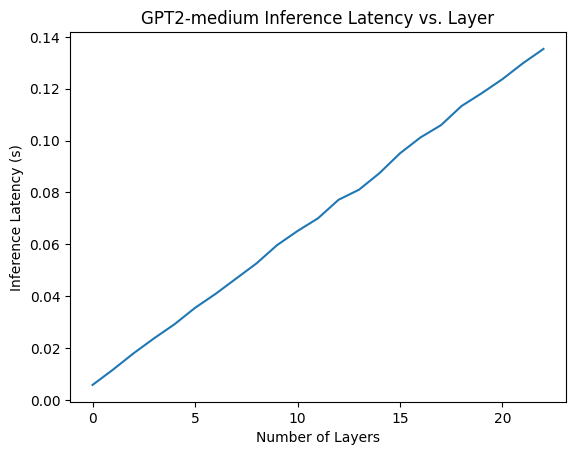

In [53]:
from matplotlib import pyplot as plt

plt.plot(avg_times)
plt.title("GPT2-medium Inference Latency vs. Layer")
plt.xlabel("Number of Layers")
plt.ylabel("Inference Latency (s)")
